# Classification

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [3]:
df = pd.read_csv("data_frames/full_df_DBNL_OCR.csv", compression="gzip")

In [4]:
df.head()

,filename,text_ground,genre,subgenre,text_ocr,title,year,edition
0,_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk
1,_vad003182401,\n\n\n\n\n\nBoekbeschouwing.\nMijne Gronden vo...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,\n\nBOIKBESCHOUWING \n\nVOOR \ni824. \n\n\nVAR...,Vaderlandsche letteroefeningen. Jaargang 1824,1824,1ste druk
2,_taa001taal01,\n\n\n\n\nVoorbericht.\nIndien de waarde eener...,sec - taalkunde,tijdschrift / jaarboek,﻿D ETA ALG I D S.\r\n\r\nD ETA ALG I D S.\r\nT...,De Taalgids. Jaargang 1,1859,1ste druk
3,_vad003179201,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTEROEFENINGEN\r\n-\r\n\r\nv 0 0 R \r\n1 792...,Vaderlandsche letteroefeningen. Jaargang 1792,1792,1ste druk
4,_vad003179301,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTER -OEFENINGEN \r\n\r\n\r\nVOOR \r\n\r\n79...,Vaderlandsche letteroefeningen. Jaargang 1793,1793,1ste druk


In [5]:
df["genre"].value_counts()

sec - letterkunde,non-fictie         77
poëzie                               46
non-fictie                           31
sec - taalkunde                      25
proza,sec - letterkunde              17
proza                                 9
proza,poëzie,non-fictie               5
sec - letterkunde                     3
poëzie,jeugdliteratuur                2
poëzie,sec - letterkunde              2
sec - letterkunde,jeugdliteratuur     1
proza,drama                           1
Name: genre, dtype: int64

In [6]:
def consolidate_classes(original_class):
    "Put together the main classes"
    
    if original_class in ["sec - letterkunde,non-fictie","proza,sec - letterkunde","proza"]:
        return "sec - letterkunde"
    elif "poëzie" in original_class:
        return "poëzie"
    elif original_class == "sec - taalkunde":
        return "sec - taalkunde"
    elif original_class == "non-fictie":
        return "non-fictie"
    return np.nan

In [9]:
%%time
jellyfish.levenshtein_distance(df["text_ground"].values[0][:1000],df["text_ocr"].values[0][:1000])

CPU times: user 2.61 ms, sys: 278 µs, total: 2.89 ms
Wall time: 2.92 ms


869

In [ ]:
#TODO: add a distance to get an idea of OCR quality. Note there is a mismatch at the beginning of the texts.

In [9]:
df["consolidated_genre"] = df["genre"].apply(consolidate_classes)

In [10]:
df.head()

,filename,text_ground,genre,subgenre,text_ocr,title,year,edition,consolidated_genre
0,_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk,sec - letterkunde
1,_vad003182401,\n\n\n\n\n\nBoekbeschouwing.\nMijne Gronden vo...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,\n\nBOIKBESCHOUWING \n\nVOOR \ni824. \n\n\nVAR...,Vaderlandsche letteroefeningen. Jaargang 1824,1824,1ste druk,sec - letterkunde
2,_taa001taal01,\n\n\n\n\nVoorbericht.\nIndien de waarde eener...,sec - taalkunde,tijdschrift / jaarboek,﻿D ETA ALG I D S.\r\n\r\nD ETA ALG I D S.\r\nT...,De Taalgids. Jaargang 1,1859,1ste druk,sec - taalkunde
3,_vad003179201,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTEROEFENINGEN\r\n-\r\n\r\nv 0 0 R \r\n1 792...,Vaderlandsche letteroefeningen. Jaargang 1792,1792,1ste druk,sec - letterkunde
4,_vad003179301,\n\n\n\n\n\nAlgemeene Vaderlandsche Letter-oef...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,LETTER -OEFENINGEN \r\n\r\n\r\nVOOR \r\n\r\n79...,Vaderlandsche letteroefeningen. Jaargang 1793,1793,1ste druk,sec - letterkunde


In [11]:
df.dropna(subset=['consolidated_genre'], inplace=True)

In [12]:
df.shape

(214, 9)

### Setup and pre-processing

In [13]:
!python -m spacy download nl


    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/nl_core_news_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/nl

    You can now load the model via spacy.load('nl')



In [14]:
"""
sample_ground = df["text_ground"].sample(n=sample_size, random_state=seed)
sample_ocr = df["text_ocr"].sample(n=sample_size, random_state=seed)
labels = df["consolidated_genre"].sample(n=sample_size, random_state=seed)
"""

'\nsample_ground = df["text_ground"].sample(n=sample_size, random_state=seed)\nsample_ocr = df["text_ocr"].sample(n=sample_size, random_state=seed)\nlabels = df["consolidated_genre"].sample(n=sample_size, random_state=seed)\n'

In [121]:
sample_ground = df["text_ground"].values
sample_ocr = df["text_ocr"].values
labels = df["consolidated_genre"].values

In [122]:
print(len(sample_ground))

214


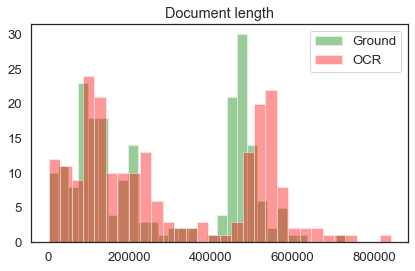

In [123]:
sns.distplot([len(x.split()) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x.split()) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

In [124]:
# trim, just to speed up experiments

LIMIT = 100000

sample_ground = [x[:LIMIT] for x in sample_ground]
sample_ocr = [x[:LIMIT] for x in sample_ocr]

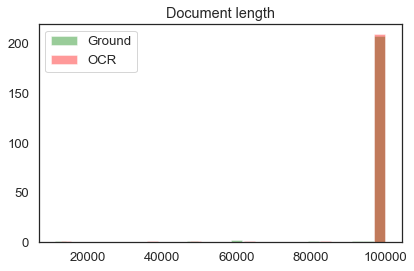

In [125]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

#### Pre-processing

* Remove stop-words
* Lemmatize
* Lowercase
* Remove tokens shorter than 3 characters
* Add frequent bigrams

*TODO: test without pre-processing.*

In [126]:
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS
STOPWORDS.add("eene")

In [131]:
%%time

processed_docs = list()
for doc in nlp.pipe(sample_ocr, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token.lower() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

CPU times: user 21min 23s, sys: 4min 31s, total: 25min 55s
Wall time: 11min 56s


In [132]:
docs = processed_docs
del processed_docs

"""
# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 20 times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
"""

"\n# Add bigrams\nfrom gensim.models.phrases import Phrases\n# Add bigrams to docs (only ones that appear 20 times or more). A better approach would be to use a chi_sq test.\nbigram = Phrases(docs, min_count=25)\nfor idx in range(len(docs)):\n    for token in bigram[docs[idx]]:\n        if '_' in token:\n            # Token is a bigram, add to document.\n            docs[idx].append(token)\n"

In [133]:
# CHANGE this
#docs_ground = docs
docs_ocr = docs

In [134]:
# save corpora
import pickle

with open('WORK_IN_PROGRESS_classification/docs_ground.pkl', 'wb') as handle:
    pickle.dump(docs_ground, handle)
with open('WORK_IN_PROGRESS_classification/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)
with open('WORK_IN_PROGRESS_classification/labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle)

#### Start from the pre-processed corpus

In [135]:
# load corpora
import pickle

docs_ground = list()
docs_ocr = list()
labels = list

with open('WORK_IN_PROGRESS_classification/docs_ground.pkl', 'rb') as handle:
    docs_ground = pickle.load(handle)
with open('WORK_IN_PROGRESS_classification/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)
with open('WORK_IN_PROGRESS_classification/labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

In [136]:
docs_ground[0][:10]

['boekbeschouwing',
 'gemoedsgesteldheid',
 'david',
 'onder',
 'zijne',
 'verschillende',
 'lotgevallen',
 'zijne',
 'psalmen',
 'opgemaakt']

In [137]:
docs_ocr[0][:10]

['sis',
 'oekbeschouwi',
 'voor',
 'erland',
 'scfie',
 'letteroefeningen',
 'tij',
 'schr',
 'van',
 'kunsten']

## Basic Sklearn

In [138]:
from collections import Counter

c = Counter(labels)
c

Counter({'sec - letterkunde': 103,
         'sec - taalkunde': 25,
         'non-fictie': 31,
         'poëzie': 55})

In [139]:
from sklearn.model_selection import train_test_split

train_g, test_g, labels_train_g, labels_test_g = train_test_split(sample_ground, labels, test_size=0.2, random_state=seed)
train_o, test_o, labels_train_o, labels_test_o = train_test_split(sample_ocr, labels, test_size=0.2, random_state=seed)

In [140]:
# Feature extractors

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect_g = CountVectorizer(min_df=2) # remove terms only in one doc, useless
tfidf_vect_g = TfidfVectorizer(min_df=2) # remove terms only in one doc, useless
count_vect_o = CountVectorizer(min_df=2) # remove terms only in one doc, useless
tfidf_vect_o = TfidfVectorizer(min_df=2) # remove terms only in one doc, useless

count_tr_g = count_vect_g.fit(train_g)
count_tr_o = count_vect_o.fit(train_o)
tfidf_tr_g = tfidf_vect_g.fit(train_g)
tfidf_tr_o = tfidf_vect_o.fit(train_o)

X_train_g_counts = count_tr_g.transform(train_g)
X_train_g_counts.shape
X_train_o_counts = count_tr_o.transform(train_o)
X_train_o_counts.shape

X_train_g_tfidf = tfidf_tr_g.transform(train_g)
X_train_o_tfidf = tfidf_tr_o.transform(train_o)
X_train_o_tfidf.shape

(171, 63317)

In [141]:
X_train_g_tfidf.shape

(171, 57500)

##### Counts

In [142]:
from sklearn.naive_bayes import MultinomialNB

clf_g = MultinomialNB().fit(X_train_g_counts, labels_train_g)
clf_o = MultinomialNB().fit(X_train_o_counts, labels_train_o)

In [164]:
from sklearn import svm

# linear works well here
clf_g = svm.SVC(decision_function_shape='ovr').fit(X_train_g_counts, labels_train_g)
clf_o = svm.SVC(decision_function_shape='ovr').fit(X_train_o_counts, labels_train_o)

In [181]:
from sklearn.ensemble import RandomForestClassifier

clf_g = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_g_counts, labels_train_g)
clf_o = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_o_counts, labels_train_o)

In [186]:
from sklearn.neural_network import MLPClassifier

clf_g = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_g_counts, labels_train_g)
clf_o = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_o_counts, labels_train_o)

In [187]:
X_test_g_counts = count_tr_g.transform(test_g)
X_test_g_tfidf = tfidf_tr_g.transform(test_g)

predicted = clf_g.predict(X_test_g_counts)
np.mean(predicted == labels_test_g)

0.8372093023255814

In [188]:
from sklearn import metrics
print(metrics.classification_report(labels_test_g, predicted))
print(metrics.confusion_matrix(labels_test_g, predicted))

                   precision    recall  f1-score   support

       non-fictie       0.86      0.86      0.86         7
           poëzie       0.79      0.73      0.76        15
sec - letterkunde       1.00      0.94      0.97        17
  sec - taalkunde       0.50      0.75      0.60         4

        micro avg       0.84      0.84      0.84        43
        macro avg       0.79      0.82      0.80        43
     weighted avg       0.86      0.84      0.84        43

[[ 6  1  0  0]
 [ 1 11  0  3]
 [ 0  1 16  0]
 [ 0  1  0  3]]


In [189]:
X_test_o_counts = count_tr_o.transform(test_o)
X_test_o_tfidf = tfidf_tr_o.transform(test_o)

predicted = clf_o.predict(X_test_o_counts)
np.mean(predicted == labels_test_o)

0.9069767441860465

In [190]:
from sklearn import metrics
print(metrics.classification_report(labels_test_g, predicted))
print(metrics.confusion_matrix(labels_test_g, predicted))

                   precision    recall  f1-score   support

       non-fictie       0.78      1.00      0.88         7
           poëzie       0.92      0.80      0.86        15
sec - letterkunde       0.94      1.00      0.97        17
  sec - taalkunde       1.00      0.75      0.86         4

        micro avg       0.91      0.91      0.91        43
        macro avg       0.91      0.89      0.89        43
     weighted avg       0.92      0.91      0.91        43

[[ 7  0  0  0]
 [ 2 12  1  0]
 [ 0  0 17  0]
 [ 0  1  0  3]]


##### TfIdf

In [148]:
from sklearn.naive_bayes import MultinomialNB

clf_g = MultinomialNB().fit(X_train_g_tfidf, labels_train_g)
clf_o = MultinomialNB().fit(X_train_o_tfidf, labels_train_o)

In [154]:
from sklearn import svm

# RBF works well here
clf_g = svm.SVC(gamma=2, C=1, decision_function_shape='ovr').fit(X_train_g_tfidf, labels_train_g)
clf_o = svm.SVC(gamma=2, C=1, decision_function_shape='ovr').fit(X_train_o_tfidf, labels_train_o)

In [175]:
from sklearn.ensemble import RandomForestClassifier

clf_g = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_g_tfidf, labels_train_g)
clf_o = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_o_tfidf, labels_train_o)

In [191]:
from sklearn.neural_network import MLPClassifier

clf_g = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_g_tfidf, labels_train_g)
clf_o = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_o_tfidf, labels_train_o)

In [192]:
X_test_g_counts = count_tr_g.transform(test_g)
X_test_g_tfidf = tfidf_tr_g.transform(test_g)

predicted = clf_g.predict(X_test_g_tfidf)
np.mean(predicted == labels_test_g)

0.8604651162790697

In [193]:
from sklearn import metrics
print(metrics.classification_report(labels_test_g, predicted))
print(metrics.confusion_matrix(labels_test_g, predicted))

                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.85      0.73      0.79        15
sec - letterkunde       0.81      1.00      0.89        17
  sec - taalkunde       1.00      0.75      0.86         4

        micro avg       0.86      0.86      0.86        43
        macro avg       0.91      0.84      0.87        43
     weighted avg       0.87      0.86      0.86        43

[[ 6  1  0  0]
 [ 0 11  4  0]
 [ 0  0 17  0]
 [ 0  1  0  3]]


In [194]:
X_test_o_counts = count_tr_o.transform(test_o)
X_test_o_tfidf = tfidf_tr_o.transform(test_o)

predicted = clf_o.predict(X_test_o_tfidf)
np.mean(predicted == labels_test_o)

0.8837209302325582

In [195]:
from sklearn import metrics
print(metrics.classification_report(labels_test_g, predicted))
print(metrics.confusion_matrix(labels_test_g, predicted))

                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.86      0.80      0.83        15
sec - letterkunde       0.85      1.00      0.92        17
  sec - taalkunde       1.00      0.75      0.86         4

        micro avg       0.88      0.88      0.88        43
        macro avg       0.93      0.85      0.88        43
     weighted avg       0.89      0.88      0.88        43

[[ 6  1  0  0]
 [ 0 12  3  0]
 [ 0  0 17  0]
 [ 0  1  0  3]]
